## Tutorial 2 - the Survey and FID classes
The tutorial for the Survey class is covering the definition and adjustments for simple FID experiments as well as the site parameters as magnetic field, tx and rx definition, pulse moments and many more.

Main Focus is on the import of a dataset using simple arrays. Thus tutorial explains all the steps needed and shows where COMET stores the different information.

Two complex classes are needed directly for this and presented here. Furthermore the loop class presented in the first example are used.

This script does not calculate anything extensive. It's only purpose is to give you a feeling on how to use the survey and fid class and where to put your input information.

In [1]:
%matplotlib inline
# import main modules from comet and other classes
from comet import pyhed as ph
from comet import snmr
import numpy as np # numerics
import matplotlib.pyplot as plt # plotting

ph.log.setLevel(20) # INFO, see Loop tutorial

## Importing data 1
There are several ways to import data. Here we show you the manually way, convinience functions are available for MRSMatlab files.  The basic function for importing raw data need at least four arrays:
* data (1D vector, complex), 
* error (1D vector, complex),
* times (1D vector, float)
* pulses (1D vector, float)

* optionally phases (1D vector, float)

In this tutorial we take some previously saved vectors from a csv file (you have to modify the import with respect to your data file format). Numpy has some easy and very flexible options when it comes to importing ascii files, e.g.

``data = np.genfromtxt('datafile', **kwargs)``

See [genfromtxt API doc](https://docs.scipy.org/doc/numpy/reference/generated/numpy.genfromtxt.html) for options.

In [2]:
# Here we simply import an npz (numpy compressed vector) file.
# importing those we get numpy arrays of various shapes (see console)
data_npz = np.load('tut2_data.npz')
# Data
data = data_npz['data']
print('data', data.shape, data.dtype)
# Error
error = data_npz['error']
print('error', error.shape, error.dtype)
# Pulses
pulses = data_npz['pulses']
print('pulses', pulses.shape, pulses.dtype)
# Phases (not needed for rotated amplitude inversion)
phases = data_npz['phases']
print('phases', phases.shape, phases.dtype)
# time vector
times = data_npz['times']
print('times', times.shape, times.dtype)

data (24, 975) complex128
error (24, 975) float64
pulses (24,) float64
phases (24,) float64
times (975,) float64


## Importing data 2

Now we have several arrays and need to store them in the correct objects for COMET to use them. This is the main purpose of the survey class and the FID's. Every FID represents one measurement in the field, the survey represents the field and all the global configurations. The survey class also manages the loop classes introduced in the first tutorial.

In [3]:
# Now we create an empty survey class representing our site
site = snmr.survey.Survey()
print(site)

SNMR Survey: 0 loops , 0 soundings


The survey class is empty. It holds no references to loops or measurements so far. In order to put our data in, we need to define our measurements. This needs all the loops used on this site so we can refer to them when initializing the FID's. We now quickly add some loops to the Survey (Loop classes are explained in detail in the first tutorial). 

In [4]:
# We start defining three half-overlapping loops
# (see Tutorial 1 on Loop classes)
loop0 = ph.loop.buildRectangle([[-40, -20], [0, 20]], max_length=2)
loop1 = ph.loop.buildRectangle([[-20, -20], [20, 20]], max_length=2)
loop2 = ph.loop.buildRectangle([[0, -20], [40, 20]], max_length=2)
# Three 40 * 40 square loops from -40 to 40 meter in x

# let's add them to our manager survey class and have a look
site.addLoop([loop0, loop1, loop2])
print(site)
print(site.loops)

SNMR Survey: 3 loops , 0 soundings
[closed rectangle, 84 dipoles at (-20.0, -0.0, 0.0), 40.0 x 40.0 m
 closed rectangle, 84 dipoles at (-0.0, -0.0, 0.0), 40.0 x 40.0 m
 closed rectangle, 84 dipoles at (20.0, -0.0, 0.0), 40.0 x 40.0 m]


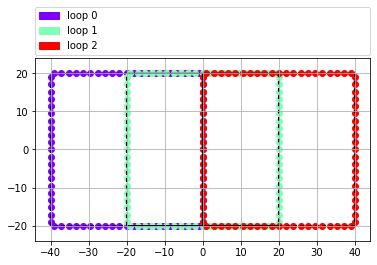

In [5]:
ph.plot.showLoopLayout(*site.loops);

### The FID class
FID stands for free induction decay. See also its [API Documentation](https://comet-project.readthedocs.io/en/latest/classes.html#comet.snmr.survey.FID).
Finally we define which loop is used as transmitter and receiver to define our NMR experiments.

In [6]:
site.createSounding(tx=0, rx=0)
# A coincident sounding using the first (in Python 0!) loop as receiver and transmitter
# let's take all combinations:
for tx_i in range(3):
    for rx_i in range(3):
        site.createSounding(tx=tx_i, rx=rx_i)

print(site.fids)
# Note that the sounding using tx=0 and rx=0 is not created again.

[FID(Tx: 0, Rx: 0), FID(Tx: 0, Rx: 1), FID(Tx: 0, Rx: 2), FID(Tx: 1, Rx: 0), FID(Tx: 1, Rx: 1), FID(Tx: 1, Rx: 2), FID(Tx: 2, Rx: 0), FID(Tx: 2, Rx: 1), FID(Tx: 2, Rx: 2)]


As we are setting everthing up, we can might as well take a small detour to define our earth and resistivity.

For computing the NMR kernel, we require the strength and orientation of the magnetic field, given by the total field and its inclination and the declination of the profile. Note that this will set the frequency of the loops to the corresponding Larmor frequency.

In [7]:
# earth magnetic field at site
site.setEarth(mag=48000e-9, incl=60, decl=0)
print(site.earth)

# resistivtiy distribution at site
# 1 Layer case (1000 Ohmm, 10m thickness) + halfspace (10 Ohmm)
# take larmor frequency from earth magnetic field
config = ph.config(rho=[1000, 10], d=[10], f=site.earth.larmor)
# config is also a class, however it is little more than a container...
# ... but it can be piped to the survey class
site.setLoopConfig(config)
# This sets the resistivity configuration for all loops at once
# let's check the first loop right away
print(site.loops[0].config)

### EARTH ###
Inclination: 1.047 rad (60°  0'  0")
Declination: 0.000 rad ( 0°  0'  0")
Magnitude:   48000e-9 Tesla
### LOOP CONFIGURATION ###
case:                     layered halfspace
resistivity distribution: [1000   10] [Ohm*m] (2)
layer thickness:          [10] [m] (1)
frequency:                2043.69 [Hz]
current:                  1.0 [A]
field type:               magnetic, B
field mode:               te


### Finally the data

The FID's are the target for our array imported above. We show this at the first FID as example.

In [8]:
# we just grab the first one
fid = site.fids[0]
print(fid)

FID(Tx: 0, Rx: 0)


36 gates


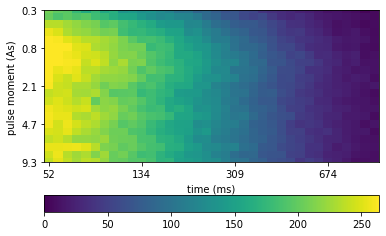

In [9]:
# Set data, error and times, phases (unrotated)
fid.setRawDataErrorAndTimes(data, error, times, phases=phases,
                            rotated=False)
# Pulse moments (in Ampere-seconds, NOT amperes!)
fid.setPulses(pulses)
# Note that if no pulse vector is given, a default one is available 
# (e.g. for synthetic studies)

# For gating the data, define the number of desired gates
# (sometimesthe first gates are empty and therefore deleted, 
# so you might end up a few gates short)
fid.gating(num_gates=42)
print(len(fid.gates), "gates")
# plot example for one fid
# make figure with one axis to plot stuff into
fig, ax = plt.subplots()
# fills a given plot axis with a gated fid plot
ax, cb = ph.plot.drawFid(ax, fid, to_plot='abs')

### Some last things

There is more to the FID class. Here are a few examples on how to change the settings.

In [10]:
# There are a lot of setter functions, e.g.

fid.setFrequencyOffset(2.3) # in Hertz

# definition of time gates, if gating is not used
fid.setGates([0, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0], midpoints=False)
# first gate between 0 and 0.1, second between 0.1 and 0.2 and so on...
# Note that instead of the gate centers its boundaries are set as
# the gate length is needed to compute individual noise levels.

# set pulse (s) and deadtime (s) of the measuring device
fid.setPulseDuration(0.04, deadtime_device=0.005)
# the effective deadtime is calculated internally summing up the deadtime
# of the device and half of the pulse duration
print('Effective deadtime: {:.3f} s'.format(fid.deadtime))

# Define the transmitter/receiver indices and turns of the loop
fid.setTx(0, turns=1)  # stored in fid.tx_index and fid.tx_turns

# same for rx
fid.setRx(1, turns=1)  # stored in fid.rx_index and fid.rx_turns

# Note: set tx and rx can be used if the loops of the survey class are imported after the FID data,
# however usually you define them at the creation of the fids via "createSounding(tx=...)"
# as shown above.
print(fid)

Effective deadtime: 0.025 s
FID(Tx: 0, Rx: 1)
